#### Quick look at the data

In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
import gsw
import pandas as pd
import pyproj
import psutil

import functions
import saildrone_processing
import front_detection

In [2]:
plt.rc('font', size=12)

### Load in altimetry data

In [38]:
# adt = functions.import_cmems('adt', 
#       'https://my.cmems-du.eu/thredds/dodsC/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D', 
#       'mjakes', 'ohw_22_MJ', -180, 180, -65, -45, '2019-01-01', '2019-03-01')

### Saildrone data

Circumpolar track around the Southern Ocean from 2019.

In [5]:
ds_saildrone = xr.open_mfdataset("~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc", chunks='auto')

In [6]:
# subset of variables from the dataset
variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

df = saildrone_processing.prepare_data(ds_saildrone, variables, aggregate_method='mean')

In [7]:
distance = functions.distFromStart(df.latitude.values, df.longitude.values)
df['distance_km'] = distance

In [18]:
mean_sea_level = adt.mean(dim = 'time')

NameError: name 'adt' is not defined

In [10]:
adt_levels = np.arange(-1.5,1,0.25)

(-180.0, 180.0)

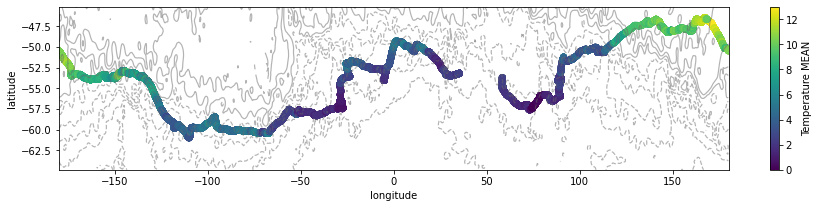

In [11]:
fig, ax = plt.subplots(figsize = (15,3))
plt.scatter(df.longitude, df.latitude, c = df.TEMP_CTD_RBR_MEAN, vmin = 0, vmax = 13)

CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Temperature MEAN')

plt.xlim(-180,180)

# TO DO: bin the ADT values into longitude (and time) bins so that the ADT contours on the map show the mean ADT during that part of the saildrone trajectory

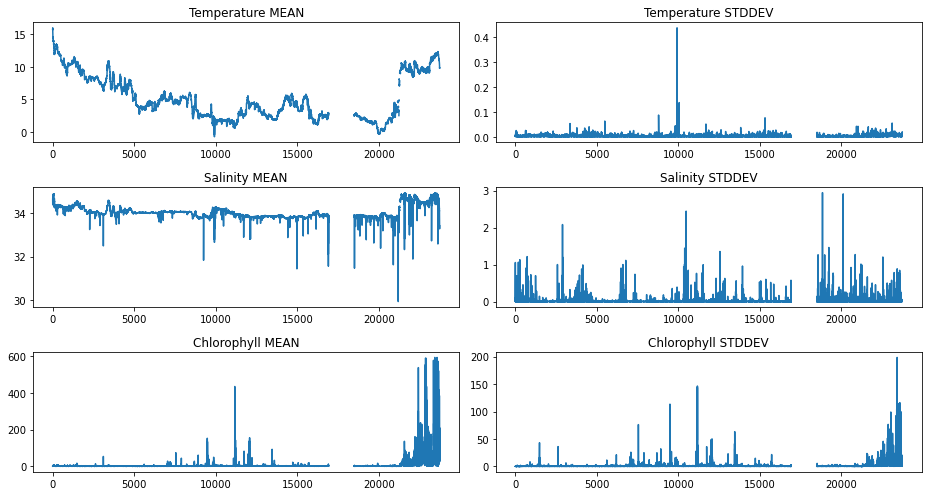

In [22]:
# Some timeseries plots to have a look at the data 
x = df.time
x = df.distance_km

fig, axs = plt.subplots(3, 2, figsize = (13,7))
axs = axs.flatten()

axs[0].plot(x, df.TEMP_CTD_RBR_MEAN)
axs[0].set_title('Temperature MEAN')

axs[1].plot(x, df.TEMP_CTD_RBR_STDDEV)
axs[1].set_title('Temperature STDDEV')

axs[2].plot(x, df.SAL_RBR_MEAN)
axs[2].set_title('Salinity MEAN')

axs[3].plot(x, df.SAL_RBR_STDDEV)
axs[3].set_title('Salinity STDDEV')

axs[4].plot(x, df.CHLOR_RBR_MEAN)
axs[4].set_title('Chlorophyll MEAN')

axs[5].plot(x, df.CHLOR_RBR_STDDEV)
axs[5].set_title('Chlorophyll STDDEV')

plt.tight_layout(h_pad = 1.2)

### ADCP data

In [8]:
adcp = xr.open_dataset('~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc')

In [4]:
# TO DO: ADCP processing - resample to every 5 minutes to match the saildrone data (use ffill?)

In [9]:
adcp_vars = [
    'vel_east',
    'vel_north',
    'vel_up']

ds_adcp = adcp[adcp_vars].isel(trajectory = 0)

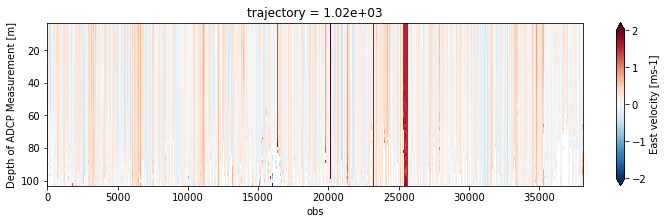

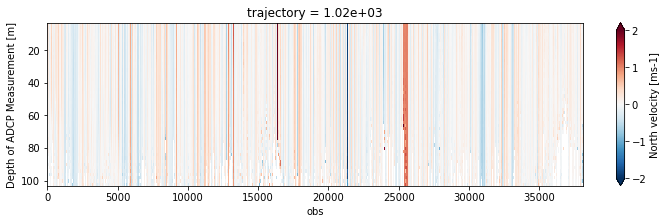

In [10]:
fig, ax = plt.subplots(figsize = (12,3))
ds_adcp.vel_east.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (12,3))
ds_adcp.vel_north.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

In [25]:
st, en = 50, 500

lons = ds_adcp.longitude[st:en]
lats = ds_adcp.latitude[st:en]
u = ds_adcp.vel_east[st:en]
v = ds_adcp.vel_north[st:en]

In [26]:
along_strm_brng = functions.stream_bearing(lons, lats)

In [27]:
velocity_brng = functions.uv_bearing(u, v)

In [28]:
angle_rad = np.deg2rad(along_strm_brng)
y = 0.3 * np.cos(angle_rad) 
x = 0.3 * np.sin(angle_rad) 

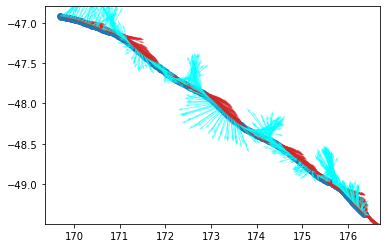

In [30]:
fig, ax = plt.subplots(figsize = (6,4))
plt.scatter(lons, lats)
plt.quiver(lons[:-1], lats[:-1], x, y, color = 'tab:red', scale = 3, alpha = 0.6)
plt.quiver(lons, lats, u.mean(dim = 'cell_depth'), v.mean(dim = 'cell_depth'),  color = 'cyan', scale = 3, alpha = 0.6)

### Rotated velocities

In [31]:
u_rot, v_rot = functions.rotate_vels(ds_adcp.vel_east, ds_adcp.vel_north, ds_adcp.longitude, ds_adcp.latitude)

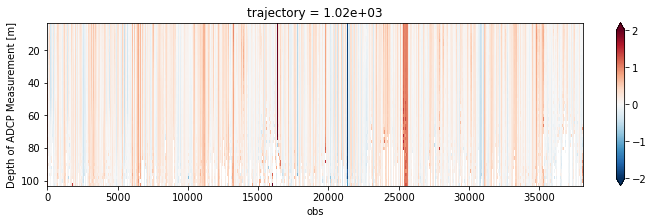

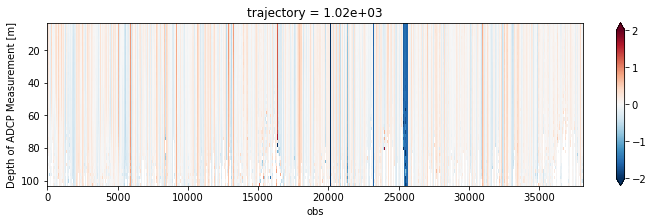

In [32]:
fig, ax = plt.subplots(figsize = (12,3))
u_rot.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (12,3))
v_rot.plot(x = 'obs', vmin = -2, vmax = 2, cmap = 'RdBu_r')
ax.invert_yaxis()

In [109]:
# ds_adcp.assign_coords(distance_km = (('distance'), distance))

## Front detection

In [33]:
# input the data variable that you want to find fronts with
var = 'TEMP_CTD_RBR_MEAN'

# TO DO: Discuss what criterion we should use for different variables.
criterion = [0.005, 0.01, 0.05, 0.1, 0.5] 

In [35]:
temp_fronts = front_detection.detect_grad_1d(df, var, criterion, x = 'distance_km', x_bin = 20, min_obs = 10)

(-180.0, 180.0)

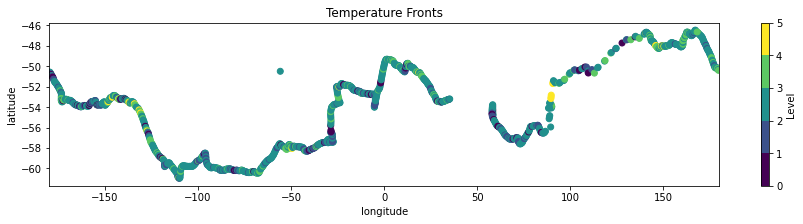

In [39]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(temp_fronts.longitude, temp_fronts.latitude, c = temp_fronts.level, norm = norm)

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Level', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Temperature Fronts')
plt.xlim(-180,180)

In [40]:
# Why is there a random point on this scatter plot? Could be to do with taking the mean of lats and lons in each group? 